# World Coordinate System Basics

Let's learn a little about how WCS systems work!

First here are some references:

- [The SIP Convention for Representing Distortion in FITS Image Headers](http://tdc-www.harvard.edu/wcstools/SIP_distortion_v1_0.pdf) by Shupe and Hook, 2008
- [FITS standard](https://fits.gsfc.nasa.gov/fits_wcs.html) by NASA
- [Representations of world coordinates in FITS](https://arxiv.org/pdf/astro-ph/0207407) by Greisen and Calabretta, 2002



In [1]:
# %pip install ipympl ipywidgets matplotlib numpy # uncomment if you dont have the required packages
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

## Terminology

We will be dealing with three coordinate systems, so first lets define some clear teminology to be extra specific about what we are talking about. "Three coordinate systems?" you say, "yes" I say sullenly, here they are:

### World Coordinates: 

These are coordinates on the celestial sphere, they will be notated with `ra` and `dec` where `ra` (right ascension) is an angle around the equator (equivalent to longitude) and goes from $0$ to $2\pi$, `dec` (declination) is the angle from north to south (equivalent to latitude) and goes from $\pi/2$ to $-\pi/2$ with zero at the equator. 

These angles are often in degrees and are the values that will be reported in surveys and catalogues. They are useful for locating something in the sky (hence catalogues), but not useful for much else. For example, you may imagine that two coordinates `(ra, dec)` and `(ra + 1arcsec, dec)` separated by one arcsecond are in fact one arcsecond appart, well weary traveler, you would be wrong. In fact, they could be separated by much much less than one arcsecond if they are near the poles since `ra` is a longitude coordinate (dec is usually pretty chill though). This is a cautionary reminder that `ra, dec` are polar coordinates, and even for small regions on the sky they should be assumed to make no sense. I must never catch you writing $\sqrt{ra^2 + dec^2}$ (gives me chills just writing it).

### Tangent Plane coordinates: 

These are coordinates on a flat plane which is tangent to the celestial sphere at some point. The origin $(0,0)$ is located at the point of contact with the celestial sphere (typically) and the positive y-axis is typically oriented towards north. These coordinates are notated with `x` and `y` and behave as a typical cartesian grid (Sir Alfred Cartese himself would be proud). `x/y` are often written in degrees, though it can be useful to change them to arcsec; either way, this is only valid for small angles since the tangent plane is only a construct for convenience and eventually it diverges too much from the celestial sphere to be a useful approximation.

### Pixel Coordinates: 

These are the coordinates of the pixels in a detector. They will be notated with `i` and `j` and they index the pixels meaning that `[0,0]` is the center of the first pixel (the pixel which would be retrieved with `image[0,0]`). Note that sometimes people will use "one indexing" where the first pixel is actually indexed as `[1,1]` (everyone makes mistakes I guess). Since the indices give the center of the pixel, that means that the edges of the image actually extend half a pixel further out in each direction, so the bottom corner of the image is at `[-0.5, -0.5]` slightly into the negatives (this is not the most offensive coordinate quirk you will see today). Note as well that it is perfectly ok to have fractional values for `i/j` since they are continuous coordinates, its just that their integer values line up with the pixel centers.

While not necessary, the reference location in the pixel grid about which other calculations are done (transformation to tangent plane coordinates) is usually the center of the image `[n_i//2, n_j//2]`. This can be thought of as the `Optical Axis` the center point of the optical path, though due to distortions this is often slightly wrong.

### FITS Header terminology

Most astronomical images come in the form of a FITS file, which is a flexible way for images to be trasported between systems along with a bunch of metadata. There are conventions for this metadata so that most people use roughly the same names for things. Let's list a few of the most common ones here:

- `CRVAL`: This is the `(ra, dec)` coordinates of where the tangent plane `(0,0)` meets the celestial sphere
- `CRPIX`: This is the `[i, j]` coordinates where the pixel grid is anchored to the tangent plane `(0,0)` (thus it is also the coordinate which translates to the `CRVAL` coordinate)
- `cdelt` or `CD`: This encodes the linear component of the transformation between pixel grid and tangent plane, it is usually written in FITS as four separate keys `CD1_1`, `CD1_2`, `CD2_1`, `CD2_2` which are the components of a matrix.
- `CTYPE`: This key tells you what kind of projection is used between the world and tangent plane, which usually looks like `RA---TAN-SIP` which means the ra coordinate is computed with a gnomonic projection (see next section) to the tangent plane, plus there are SIP distortions (see next section). And there will be another key for the dec coordinate.
- `A` and `B`: are used to index the SIP distortion coefficients, see next section for more details.

As a final caveat for everything you've read up to this point, I learned on HST data and that's where most of my information comes from. Each telescope has its own conventions/quirks, and I haven't gotten into other types of data (image cubes, spectra, polarization, etc.) that can also be stored in FITS format. Hopefully this notebook can give you some bearings if you have to learn more and act as a starting point.

![xkcd map projections](https://imgs.xkcd.com/comics/map_projections.png)

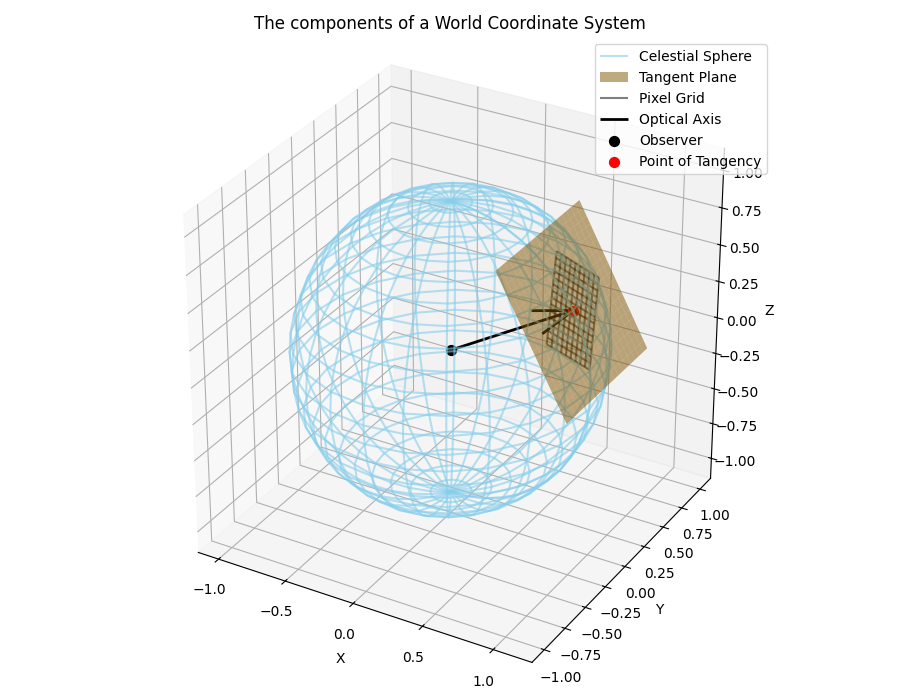

In [2]:
np.random.seed(142)
# Parameters
R = 1.0  # Radius of the sphere
theta = np.pi / 3  # polar angle (0 at north pole)
phi = 0    # azimuthal angle (0 at x-axis)

# Point on sphere
px = R * np.sin(theta) * np.cos(phi)
py = R * np.sin(theta) * np.sin(phi)
pz = R * np.cos(theta)
p = np.array([px, py, pz])

# Normal vector (same as position vector for a sphere at origin)
n = p / np.linalg.norm(p)

# Create grid for tangent plane
plane_size = 0.5
u, v = np.meshgrid(np.linspace(-plane_size, plane_size, 20),
                   np.linspace(-plane_size, plane_size, 20))

# Two orthonormal basis vectors on the tangent plane
# Generate one orthogonal to n
arbitrary = np.array([0, 0, 1]) if not np.allclose(n, [1, 0, 0]) else np.array([0, 1, 0])
t1 = np.cross(n, arbitrary)
t1 /= np.linalg.norm(t1)
t2 = np.cross(n, t1)

# Plane points
xx = p[0] + u * t1[0] + v * t2[0]
yy = p[1] + u * t1[1] + v * t2[1]
zz = p[2] + u * t1[2] + v * t2[2]

# pixel grid
image_size = 0.2
u, v = np.meshgrid(np.linspace(-image_size*1.5, image_size*1.5, 15),
                   np.linspace(-image_size, image_size, 10))
arbitrary = np.random.uniform(size = 3) - 0.5
p1 = np.cross(n, arbitrary)
p1 /= np.linalg.norm(p1)
p2 = np.cross(n, p1)
pgx = p[0] + u * p1[0] + v * p2[0]
pgy = p[1] + u * p1[1] + v * p2[1]
pgz = p[2] + u * p1[2] + v * p2[2]

# Sphere parameterization
phi_sphere = np.linspace(0, 2 * np.pi, 25)
theta_sphere = np.linspace(0, np.pi, 25)
phi_sphere, theta_sphere = np.meshgrid(phi_sphere, theta_sphere)
x_s = R * np.sin(theta_sphere) * np.cos(phi_sphere)
y_s = R * np.sin(theta_sphere) * np.sin(phi_sphere)
z_s = R * np.cos(theta_sphere)

# Plotting
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Sphere
ax.plot_wireframe(x_s, y_s, z_s, color='skyblue', alpha=0.6, edgecolor='skyblue', label="Celestial Sphere")

# Tangent plane
ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, label="Tangent Plane")

# Pixel plane
ax.plot_wireframe(pgx, pgy, pgz, color='black', alpha=0.5, label="Pixel Grid")

# Arrow from origin to point of contact
ax.quiver(0, 0, 0, px, py, pz, color='black', linewidth=2, label="Optical Axis")
ax.scatter(0, 0, 0, color='black', s=50, label='Observer')

# Tangent point
ax.scatter(px, py, pz, color='red', s=50, label='Point of Tangency')

# Axis formatting
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([1, 1, 1])
ax.set_title("The components of a World Coordinate System")
ax.legend()

plt.tight_layout()
plt.show()


## Changing Coordinate Systems

Now you know all the words and what they mean, its time to put on your thinking pants and do some math. Let's take a look at how one changes coordinate systems so you understand some of the underlying mechanics. That said, in regular situations you can treat these functions as black boxes and just assume each set of coordinates has nothing to do with each other.

### World to Plane

As an observer on Earth we are at the center of the celestial sphere, looking out. This means that any ray coming from you, the observer comes from the center of the sphere and then passes through a point on the surface of the sphere and then lands on the tangent plane. The formula for connecting the corresponding points on the sphere and the plane is called, say it with me, a Gnomonic projection. Once we know what it is, we are a google search away from the formula, from my searches the best source is [Wolfram MathWorld](https://mathworld.wolfram.com/GnomonicProjection.html) which also has nice pictures. 

![Gnomonic projection](https://mathworld.wolfram.com/images/eps-svg/GnomonicProjectionFigure_1000.svg)

If we say the contact point is at $(\rm{ra}_0, \rm{dec}_0)$ then the tangent plane coordinates are:

$$ x = \frac{\cos(\rm{dec})\sin(\rm{ra} - \rm{ra}_0)}{\cos(c)} $$
$$ y = \frac{\cos(\rm{dec}_0)\sin(\rm{dec}) - \sin(\rm{dec}_0)\cos(\rm{dec})\cos(\rm{ra} - \rm{ra}_0)}{\cos(c)} $$
$$ \cos(c) = \sin(\rm{dec}_0)\sin(\rm{dec}) + \cos(\rm{dec}_0)\cos(\rm{dec})\cos(\rm{ra} - \rm{ra}_0) $$

which is probably more than you bargained for, but there it is. 

### Plane to World

We can also do the inverse transformation to go from coordinates in the tangent plane to the world coordinates. Surprise, it's not a clean formula either, nature says to be happy its analytic, it could be worse.

$$ \rm{ra} = \rm{ra}_0 + \tan^{-1}\left(\frac{x\sin(c)}{\rho\cos(\rm{dec}_0)\cos(c) - y\sin(\rm{dec}_0)\sin(c)}\right) $$
$$ \rm{dec} = \sin^{-1}\left(\cos(c)\sin(\rm{dec}_0) + \frac{y}{\rho}\sin(c)\cos(\rm{dec}_0)\right) $$
$$ \rho^2 = x^2 + y^2 $$
$$ c = \tan^{-1}(\rho) $$


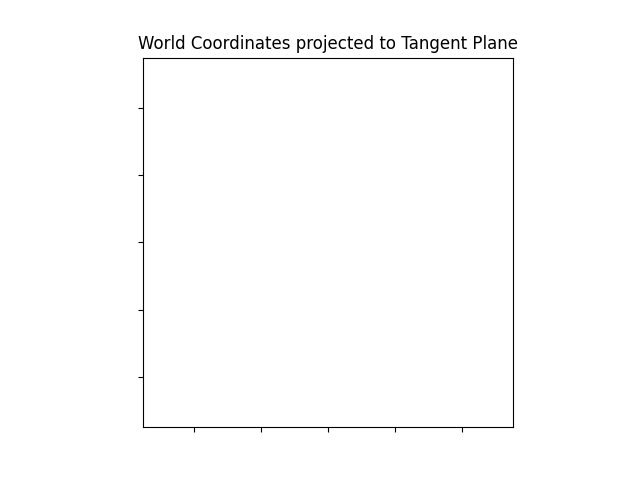

interactive(children=(FloatSlider(value=3.141592653589793, description='ra0', max=6.283185307179586, step=0.01…

In [3]:
def world_to_plane(ra, dec, ra0, dec0):    
    cosc = np.sin(dec0) * np.sin(dec) + np.cos(dec0) * np.cos(dec) * np.cos(ra - ra0)
    x = np.cos(dec) * np.sin(ra - ra0) / cosc
    y = np.cos(dec0)*np.sin(dec) - np.sin(dec0) * np.cos(dec) * np.cos(ra-ra0)
    y /= cosc
    # remove anipodal points
    c = np.arccos(cosc)
    x[c > np.pi/2] = np.nan
    y[c > np.pi/2] = np.nan
    return x, y

RA, DEC = np.meshgrid(
    np.concatenate((np.linspace(0, 2 * np.pi, 100), np.array([np.nan]))), 
    np.concatenate((np.linspace(-np.pi/2, np.pi/2, 50), np.array([np.nan]))),
)


fig, ax = plt.subplots()
x, y = world_to_plane(RA, DEC, np.pi, 0.0)
line1, *_ = ax.plot([], [], color = "skyblue")
line2, *_ = ax.plot([], [], color = "skyblue")
ax.set_title("World Coordinates projected to Tangent Plane")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect(1.0)
plt.show()

@widgets.interact(
    ra0=widgets.FloatSlider(value=np.pi, min=0, max=2*np.pi, step=0.01),
    dec0=widgets.FloatSlider(value=0.0, min=-np.pi/2, max=np.pi/2, step=0.01),
    fov=widgets.FloatSlider(value=60.0, min=10, max=340, step=1),
)
def plot_projection(ra0, dec0, fov):
    x, y = world_to_plane(RA, DEC, ra0, dec0)
    line1.set_xdata(x)
    line1.set_ydata(y)
    line2.set_xdata(x.T)
    line2.set_ydata(y.T)
    axlim = fov * np.pi / 180 / 2
    ax.set_xlim(-axlim, axlim)
    ax.set_ylim(-axlim, axlim)
    ax.grid(True, color = "orange")
    fig.canvas.draw_idle()

### Pixel to Plane

Pixels come in a nice orderly grid that translates linearly to the tangent plane... right? They dont?? Then what do they... oh dear... oh no no...

While the pixels may be in a nice orderly grid, the optics of a real world telescope is anything but orderly. The main transformation between the pixel grid and the tangent plane is just a linear transformation (matrix multiplication). However, slight imperfections along the optical path can cause the light to take slight deviations from its intended path. Since it is possible to determine the location of a bright star in an image very accurately (often less than 1/10th a pixel size), we notice these very small deviations and so they must be determined and corrected for. Here we will look at one of the most commonly use forms of correction `SIP` which stands for Simple Imaging Polynomial. As the name suggests, it uses a polynomial function to represent the pixel distortions. First, let's write out the core linear transformation. To make it look cleaner we will work entirely in centered coordinates $u = i - i_0$ and $v = j - j_0$, where the $i_0$ and $j_0$ are from `CRPIX`. Ok, here we go:

$$\left(\begin{matrix} x \\ y \end{matrix}\right) = \left(\begin{matrix} CD_{1,1} & CD_{1,2} \\ CD_{2,1} & CD_{2,2}\end{matrix}\right)\left(\begin{matrix}u \\ v\end{matrix}\right)$$

If only that was all... Instead to account for non-linearities we include a function which takes the pixel coordinates in and returns a correction to the pixel coordinates:

$$\left(\begin{matrix} x \\ y \end{matrix}\right) = \left(\begin{matrix} CD_{1,1} & CD_{1,2} \\ CD_{2,1} & CD_{2,2}\end{matrix}\right)\left(\begin{matrix}u + f(u,v) \\ v + g(u,v)\end{matrix}\right)$$

These two functions $f(u,v)$ and $g(u,v)$ could in principle be anything, but a simple (ba-dum-tis) choice is a polynomial like this:

$$ f(u,v) = \sum_{p,q}A_{p,q}u^pv^q $$
$$ g(u,v) = \sum_{p,q}B_{p,q}u^pv^q $$

### Plane to Pixel

If the pixel-to-plane transformation had been linear then we could have simply inverted the `CD` matrix and called it done, but since it is non-linear we cant do just that. Still, the choice of having the non-linear $f,g$ functions act on the pixel coordinates is a clever one, lets see why. If we simply rearrange for $u,v$ we get this:

$$\left(\begin{matrix}u \\ v\end{matrix}\right) = \left(\begin{matrix} CD_{1,1} & CD_{1,2} \\ CD_{2,1} & CD_{2,2}\end{matrix}\right)^{-1}\left(\begin{matrix} x \\ y \end{matrix}\right) - \left(\begin{matrix}f(u,v) \\ g(u,v)\end{matrix}\right)$$

which almost works, except for one minor-gigantic detail, the $f(u,v), g(u,v)$ functions depend on the $u,v$ coordinates! As a rough start, we can assume the SIP transformation is small and not changing very fast, in which case we can assume the linear transformation gets us close and then the $f,g$ functions can use the intermediate coordinates:

$$\left(\begin{matrix}U \\ V\end{matrix}\right) = \left(\begin{matrix} CD_{1,1} & CD_{1,2} \\ CD_{2,1} & CD_{2,2}\end{matrix}\right)^{-1}\left(\begin{matrix} x \\ y \end{matrix}\right)$$

and then we can get the SIP correction with $-f(U,V)$ and $-g(U,V)$ which is the same as just taking the negative of all the SIP coefficients (`A` and `B` values). However, this is only an approximation and it won't work when the distortions are especially large. In these cases you have two options. You can use a root finding algorithm to determine the true $u,v$ (which is pretty fast since $U,V$ is a good start). Alternately, you can determine a new set of functions $F(U,V)$ and $G(U,V)$ which have different coefficients:

$$ F(U,V) = \sum_{p,q}AP_{p,q}U^pV^q $$
$$ G(U,V) = \sum_{p,q}BP_{p,q}U^pV^q $$

Where it is likely necessary to include a linear term in $F,G$ on top of the `CD` matrix linear term.

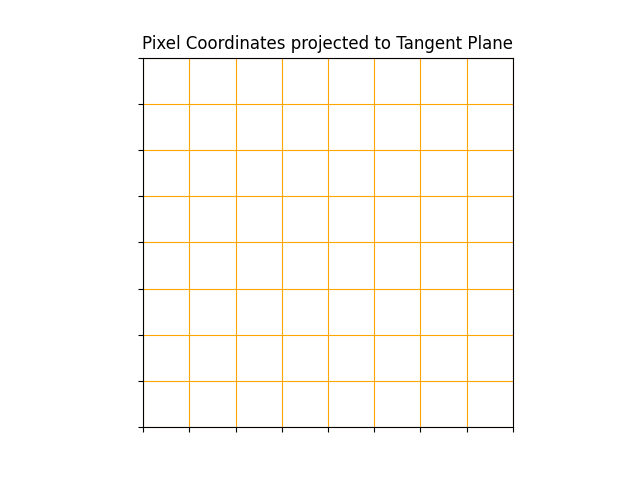

interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586, step=0.…

In [4]:
def pixel_to_plane(u, v, CD, sip_powers, sip_coefs):
    shape = u.shape
    u = u.flatten()
    v = v.flatten()
    f = sum(sip_coefs[p][0] * u ** sip_powers[p][0] * v ** sip_powers[p][1] for p in range(len(sip_coefs)))
    g = sum(sip_coefs[p][1] * u ** sip_powers[p][0] * v ** sip_powers[p][1] for p in range(len(sip_coefs)))
    w = CD @ np.stack((u + f,v + g))
    return w[0].reshape(shape), w[1].reshape(shape)

def CD(theta, pixelscale=0.05):
    return pixelscale * np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    
i, j = np.meshgrid(np.concatenate((np.arange(15), np.array([np.nan]))), np.concatenate((np.arange(20), np.array([np.nan]))))
crpix = (i[-2,-2]//2, j[-2,-2]//2)
sip_p = np.array(((0,1), (1,2), (3,1)))
sip_c = np.array(((-1e-4, 1e-3), (1e-3,-1e-4), (-4e-4, -1e-3)))
fig, ax = plt.subplots()
x, y = pixel_to_plane(i - crpix[0], j - crpix[1], CD(np.pi/3), sip_p, sip_c)
line1, *_ = ax.plot([], [], color = "k")
line2, *_ = ax.plot([], [], color = "k")
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
ax.set_title("Pixel Coordinates projected to Tangent Plane")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect(1.0)
ax.grid(True, color = "orange")
plt.show()

@widgets.interact(
    theta=widgets.FloatSlider(value=np.pi, min=0, max=2*np.pi, step=0.01),
    pixelscale=widgets.FloatSlider(value=0.05, min=0.01, max=0.1, step=0.001),
    sip11=widgets.FloatSlider(value=0.0, min=-1e-2, max=1e-2, step=1e-4),
    sip20=widgets.FloatSlider(value=0.0, min=-1e-3, max=1e-3, step=1e-5)
)
def plot_projection(theta, pixelscale=0.05, sip11=0.0, sip20=0.0):
    sip_c[1,1] = sip11
    sip_c[2,0] = sip20
    x, y = pixel_to_plane(i - crpix[0], j - crpix[1], CD(theta, pixelscale), sip_p, sip_c)
    line1.set_xdata(x)
    line1.set_ydata(y)
    line2.set_xdata(x.T)
    line2.set_ydata(y.T)
    fig.canvas.draw_idle()

## This all seems like a lot of work!

I have good news, you will likely never need the equations above. Almost everything in the WCS standard has been implimented into the very useful `astropy` package. While it mostly focuses on pixel-to-world and back again, that's all most people need. And it impliments all sorts of different projections that we haven't discussed here. It's also generally very easy to use, if your data comes in a FITS file, you can likely pass along the header and a proper WCS object will be created for you with all the relevant corrections. What a brave new world we live in with such packages in it. Below is a little example creating an astropy WCS object from scratch, beware that if you do this for your data, there is a good chance you get it wrong. For example, in HST data on top of the SIP correction for the pixels, there is another map that gives a pixel-by-pixel correction throughout the whole image! Talk about nit-picky! 

In [5]:
from astropy import wcs
from astropy.io import fits

# Create a new WCS object.  The number of axes must be set
# from the start
w = wcs.WCS(naxis=2)

w.wcs.crpix = [-234.75, 8.3393]
w.wcs.cdelt = np.array([-0.066667, 0.066667])
w.wcs.crval = [0, -90]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.wcs.set_pv([(2, 1, 45.0)])

pixcrd = np.array([[0, 0], [24, 38], [45, 98]], dtype=np.float64)
world = w.wcs_pix2world(pixcrd, 0)
pixcrd2 = w.wcs_world2pix(world, 0)

print(pixcrd)
print(pixcrd2)

[[ 0.  0.]
 [24. 38.]
 [45. 98.]]
[[ 8.52651283e-14 -1.35891298e-13]
 [ 2.40000000e+01  3.80000000e+01]
 [ 4.50000000e+01  9.80000000e+01]]


## Concluding remarks

You now know the basic transformations involved in WCS methods, to perform `pixel_to_world` one would just chain `pixel_to_plane` and `plane_to_world` together. That said, the WCS standard doesn't really use the "Tangent plane" terminology quite like I do, it is more concerned with the pixel to world conversion and makes little comment on the tangent plane as more than an intermediate step. However, each coordinate system has its own distict use. The pixel grid is where data lives, this is where you will have measurements and uncertainties. The celestial sphere is where the true positions on the sky exist, catalogues give values in world coordinates so it is possible to find them again! The tangent plane is typically the best coordinate system in which to do modelling, the cartesian grid makes for sensible distance metrics in this space and it is possible to efficiently interface between multiple images (pixel grids) through a common tangent plane independent of their relative alignment.

There is another aspect we haven't considered, there are even more coordinate systems that can be relevant for a given analysis. For some datasets it is better to represent them in galactic longitude and galactic latitude, which is a different celesial sphere. Sometimes, for example when making paralax measurements, you may need to know the precise position of the center of your current celestial sphere to compare with later observations, so you have to track that in... another coordinate system I guess? When making radial velocity or CMB measurements you will care about not just the position of your observatory, but also it's relative velocity to some reference point (another coordinate system). Then people sometimes like to change projections just because they like the way it looks (I'm looking at you Mollweide). And don't get me started on the cosmological expansion of space. All this to say, if you got to the end of this notebook thinking that you understood astronomical coordinate systems... you probably don't.

![Astronomy Numbers](https://imgs.xkcd.com/comics/astronomy_numbers.png)